# **DSIM - E01 Assignment: Zero-Crossing Rate**

Implementation of the Zero-Crossing Rate (ZCR) feature for audio classification on the Free Spoken Digit Dataset.

In [ ]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive
import tarfile
from shutil import copyfile

In [ ]:
drive.mount('/content/gdrive')
copyfile('/content/gdrive/MyDrive/Second year/First semester/Digital signals and image management/DSIM Lab/DSIM_E01_notebook/recordings.tar', 'recordings.tar')
tar = tarfile.open('recordings.tar')
tar.extractall()
tar.close()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/tmp/ipython-input-1367485218.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


In [ ]:
def identity(input):
  return input

def load_data(feature_extractor=identity, normalize=False):
  labels = []
  features = []

  for f in sorted(os.listdir('./recordings')):
    if f.endswith('.wav'):
      _, signal = wav.read('./recordings/' + f)
      cur_features = feature_extractor(signal)
      features.append(cur_features)
      label = f.split('_')[0]
      labels.append(label)


  X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

  if normalize:
      eps = 0.001
      X_train = np.array(X_train)
      X_train_mean = X_train.mean(axis=0)
      X_train_std = X_train.std(axis=0)
      X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
      X_train = [row for row in X_train]

      X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

  return X_train, X_test, y_train, y_test

In [ ]:
def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)

In [ ]:
def duration(input):
    return np.array(input.shape)

## Zero-Crossing Rate (ZCR)

The **Zero-Crossing Rate** measures how frequently the signal changes sign. It captures the frequency content of the signal: higher ZCR generally corresponds to noisier or higher-pitched sounds.

Given a discrete signal $x[n]$ of length $N$, the ZCR is defined as:

$$
ZCR = \frac{1}{N-1} \sum_{n=1}^{N-1} \mathbb{1}\left\{ \text{sign}(x[n]) \neq \text{sign}(x[n-1]) \right\}
$$

where $\text{sign}(x)$ returns $+1$, $0$, or $-1$, and $\mathbb{1}\{\cdot\}$ is the indicator function.

**Implementation notes:**
- We compare `np.sign()` of consecutive samples; a difference means a zero crossing occurred.
- We normalize by $(N-1)$ (the number of adjacent pairs) to obtain a rate independent of signal length.
- Samples exactly equal to zero are treated as having sign $0$ by `np.sign()`. A transition from positive to zero (or vice versa) will count as a crossing. This is one of many valid design choices.

In [ ]:
def zcr(input):
    signs = np.sign(input.astype(float)) # compare signs of consecutive samples
    crossings = np.sum(signs[1:] != signs[:-1]) # count sign changes between adjacent samples
    rate = crossings / (len(input) - 1) # normalize by the number of adjacent pairs
    return np.array([rate])

## 1. ZCR alone

We first evaluate the classification performance using only the ZCR feature, with hyperparameter optimization via grid search.

Number of training examples: 1350
Dimensionality of the training features: (1,)
Training completed in 2.147s

Best parameters:
 C: 1000
 gamma: 1.0

Classification report (ZCR only):
              precision    recall  f1-score   support

           0       0.23      0.47      0.31        17
           1       0.38      0.30      0.33        10
           2       0.12      0.40      0.19        15
           3       0.00      0.00      0.00        19
           4       0.15      0.36      0.22        11
           5       0.00      0.00      0.00        14
           6       0.62      0.93      0.74        14
           7       0.00      0.00      0.00        19
           8       0.08      0.06      0.07        17
           9       0.00      0.00      0.00        14

    accuracy                           0.23       150
   macro avg       0.16      0.25      0.19       150
weighted avg       0.14      0.23      0.17       150



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


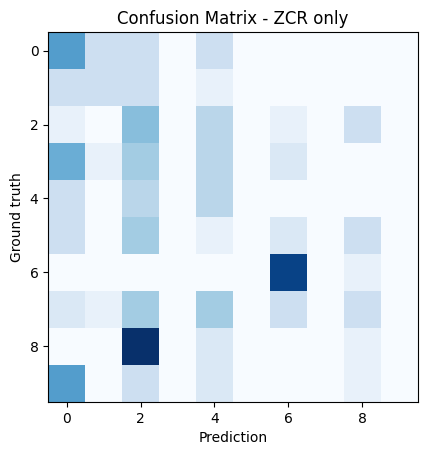

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=zcr, normalize=False)
print('Number of training examples: {}'.format(len(X_train)))
print('Dimensionality of the training features: {}'.format(X_train[0].shape))

param_grid = {'C': [100, 500, 1000],
              'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

print('\nBest parameters:')
print(' C: ' + str(clf.best_estimator_.C))
print(' gamma: ' + str(clf.best_estimator_.gamma))

y_pred = clf.predict(X_test)
print('\nClassification report (ZCR only):')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.title('Confusion Matrix - ZCR only')
plt.show()

**Observation:** ZCR alone achieves only **23% accuracy** — barely above random guessing for a 10-class problem (10%). Four classes (3, 5, 7, 9) are never predicted at all (precision = 0.00), while class 6 dominates with 93% recall. This suggests that ZCR partially discriminates certain digits (e.g., "six" may have a distinctively high or low crossing rate) but a single scalar feature is far too limited to separate 10 classes in a 1-dimensional space.

## 2. ZCR + Energy

Combining ZCR with the energy feature. Normalization is enabled since the two features have very different scales.

Dimensionality of the training features: (2,)
Training completed in 3.311s

Best parameters:
 C: 500
 gamma: 0.5

Classification report (ZCR + Energy):
              precision    recall  f1-score   support

           0       0.60      0.35      0.44        17
           1       0.23      0.70      0.35        10
           2       0.29      0.27      0.28        15
           3       0.43      0.16      0.23        19
           4       0.33      0.36      0.35        11
           5       0.35      0.50      0.41        14
           6       0.80      0.86      0.83        14
           7       0.10      0.05      0.07        19
           8       0.37      0.41      0.39        17
           9       0.31      0.29      0.30        14

    accuracy                           0.37       150
   macro avg       0.38      0.39      0.36       150
weighted avg       0.38      0.37      0.35       150



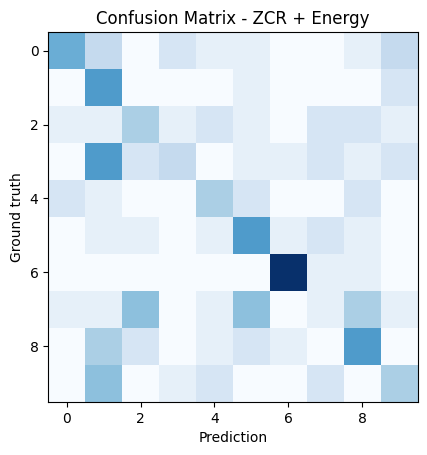

In [ ]:
def zcr_energy(input):
    return np.concatenate((zcr(input), energy(input)))

X_train, X_test, y_train, y_test = load_data(feature_extractor=zcr_energy, normalize=True)
print('Dimensionality of the training features: {}'.format(X_train[0].shape))

param_grid = {'C': [100, 500, 1000],
              'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

print('\nBest parameters:')
print(' C: ' + str(clf.best_estimator_.C))
print(' gamma: ' + str(clf.best_estimator_.gamma))

y_pred = clf.predict(X_test)
print('\nClassification report (ZCR + Energy):')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.title('Confusion Matrix - ZCR + Energy')
plt.show()

**Observation:** combining ZCR with Energy improves accuracy from 23% to **37%**. The two features are complementary: Energy captures the signal's amplitude ("volume") while ZCR captures its frequency content. All 10 classes are now predicted (no more 0.00 precision), though class 7 remains very difficult (5% recall). Normalization is essential here: Energy values are in the order of $10^6$–$10^9$ while ZCR $\in [0, 1]$. Without normalization, the SVM kernel would be dominated entirely by Energy, effectively ignoring ZCR.

## 3. ZCR + Duration

Combining ZCR with the duration feature.

Dimensionality of the training features: (2,)
Training completed in 3.577s

Best parameters:
 C: 1000
 gamma: 0.5

Classification report (ZCR + Duration):
              precision    recall  f1-score   support

           0       0.58      0.41      0.48        17
           1       0.33      0.70      0.45        10
           2       0.30      0.40      0.34        15
           3       0.38      0.16      0.22        19
           4       0.30      0.55      0.39        11
           5       0.14      0.14      0.14        14
           6       0.87      0.93      0.90        14
           7       0.19      0.16      0.17        19
           8       0.50      0.35      0.41        17
           9       0.58      0.50      0.54        14

    accuracy                           0.40       150
   macro avg       0.42      0.43      0.40       150
weighted avg       0.42      0.40      0.39       150



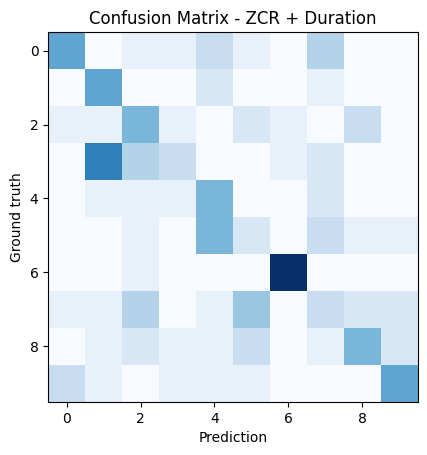

In [ ]:
def zcr_duration(input):
    return np.concatenate((zcr(input), duration(input)))

X_train, X_test, y_train, y_test = load_data(feature_extractor=zcr_duration, normalize=True)
print('Dimensionality of the training features: {}'.format(X_train[0].shape))

param_grid = {'C': [100, 500, 1000],
              'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

print('\nBest parameters:')
print(' C: ' + str(clf.best_estimator_.C))
print(' gamma: ' + str(clf.best_estimator_.gamma))

y_pred = clf.predict(X_test)
print('\nClassification report (ZCR + Duration):')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.title('Confusion Matrix - ZCR + Duration')
plt.show()

**Observation:** ZCR + Duration achieves **40% accuracy**, slightly outperforming ZCR + Energy (37%). Duration provides temporal information that complements the frequency information from ZCR. Notably, class 6 reaches 90% F1-score and class 9 reaches 54% — both higher than with ZCR + Energy. However, class 5 remains problematic (14% F1), suggesting that some digits have similar duration and ZCR profiles.

## 4. ZCR + Energy + Duration (combo2)

Combining all three features together. This extends the original `combo` (Energy + Duration) with the ZCR feature.

Dimensionality of the training features: (3,)
Training completed in 4.420s

Best parameters:
 C: 100
 gamma: 0.5

Classification report (Energy + Duration + ZCR):
              precision    recall  f1-score   support

           0       0.67      0.59      0.62        17
           1       0.33      0.70      0.45        10
           2       0.44      0.47      0.45        15
           3       0.50      0.32      0.39        19
           4       0.41      0.64      0.50        11
           5       0.36      0.36      0.36        14
           6       0.86      0.86      0.86        14
           7       0.27      0.16      0.20        19
           8       0.60      0.53      0.56        17
           9       0.67      0.71      0.69        14

    accuracy                           0.51       150
   macro avg       0.51      0.53      0.51       150
weighted avg       0.51      0.51      0.50       150



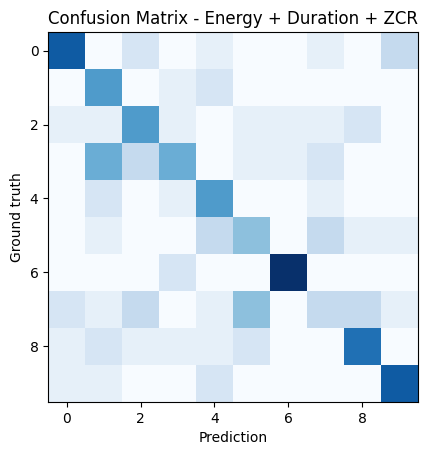

In [ ]:
def combo2(input):
    return np.concatenate((energy(input), duration(input), zcr(input)))

X_train, X_test, y_train, y_test = load_data(feature_extractor=combo2, normalize=True)
print('Dimensionality of the training features: {}'.format(X_train[0].shape))

param_grid = {'C': [100, 500, 1000],
              'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

print('\nBest parameters:')
print(' C: ' + str(clf.best_estimator_.C))
print(' gamma: ' + str(clf.best_estimator_.gamma))

y_pred = clf.predict(X_test)
print('\nClassification report (Energy + Duration + ZCR):')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.title('Confusion Matrix - Energy + Duration + ZCR')
plt.show()

**Observation:** the combination of all three features (Energy + Duration + ZCR) achieves **51% accuracy**, a significant improvement over any two-feature combination. All classes are now predicted with non-zero recall, and the confusion matrix shows a clearer diagonal pattern. The three features capture complementary information: amplitude (Energy), temporal extent (Duration), and frequency content (ZCR). Class 6 remains the easiest to classify (86% F1), while class 7 is still the hardest (20% F1).

## 5. Hyperparameter optimization with extended grid

We expand the grid search to explore a wider range of `C` and `gamma` values, and increase the number of cross-validation folds to `cv=5` for more robust parameter selection.

Training completed in 99.626s

Best parameters:
 C: 50
 gamma: 0.5
 Best CV score: 0.536

Classification report (combo2 - extended grid, cv=5):
              precision    recall  f1-score   support

           0       0.64      0.53      0.58        17
           1       0.39      0.70      0.50        10
           2       0.37      0.47      0.41        15
           3       0.55      0.32      0.40        19
           4       0.38      0.55      0.44        11
           5       0.33      0.36      0.34        14
           6       0.87      0.93      0.90        14
           7       0.27      0.16      0.20        19
           8       0.56      0.53      0.55        17
           9       0.67      0.71      0.69        14

    accuracy                           0.50       150
   macro avg       0.50      0.52      0.50       150
weighted avg       0.50      0.50      0.49       150



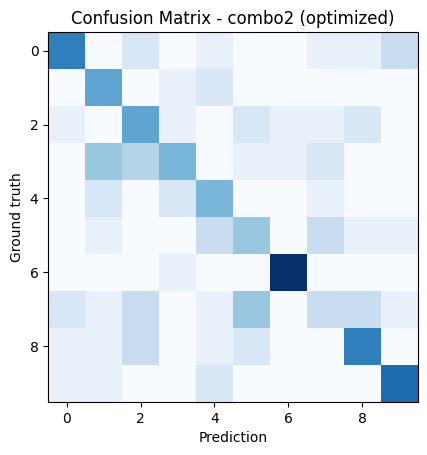

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo2, normalize=True)

param_grid = {'C': [0.1, 1, 10, 50, 100, 500, 1000, 5000],
              'gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5, n_jobs=-1)

t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

print('\nBest parameters:')
print(' C: ' + str(clf.best_estimator_.C))
print(' gamma: ' + str(clf.best_estimator_.gamma))
print(' Best CV score: %0.3f' % clf.best_score_)

y_pred = clf.predict(X_test)
print('\nClassification report (combo2 - extended grid, cv=5):')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.title('Confusion Matrix - combo2 (optimized)')
plt.show()

**Observation:** the extended grid search with `cv=5` yields **50% test accuracy** (CV score: 53.6%), essentially the same as the basic grid with `cv=2` (51%). The optimal hyperparameters shifted slightly ($C=50$, $\gamma=0.5$ vs $C=100$, $\gamma=0.5$), but the performance plateau indicates that the bottleneck is not hyperparameter tuning — it is the **limited expressiveness of 3 scalar features** for a 10-class problem. To achieve further improvement, we need richer feature representations.

## 6. Additional features

We define new features to further enrich the representation:

### Root Mean Square (RMS)

$$
RMS(x) = \sqrt{\frac{1}{N} \sum_{i=1}^{N} x_i^2}
$$

Unlike energy, RMS is normalized by signal length, making it independent of duration.

### Mean Absolute Value (MAV)

$$
MAV(x) = \frac{1}{N} \sum_{i=1}^{N} |x_i|
$$

### Standard Deviation

$$
\sigma(x) = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_i - \bar{x})^2}
$$

Captures the spread of sample amplitudes.

### Crest Factor

$$
CF(x) = \frac{\max(|x|)}{RMS(x)}
$$

Ratio of peak amplitude to RMS. Indicates how "peaky" the signal is.

In [ ]:
def rms(input):
    x = input.astype(float)
    return np.sqrt(np.mean(x**2, keepdims=True))

def mav(input):
    x = input.astype(float)
    return np.mean(np.abs(x), keepdims=True)

def std_dev(input):
    x = input.astype(float)
    return np.std(x, keepdims=True)

def crest_factor(input):
    x = input.astype(float)
    rms_val = np.sqrt(np.mean(x**2))
    if rms_val == 0:
        return np.array([0.0])
    return np.array([np.max(np.abs(x)) / rms_val])

## 7. Extended combo: all features combined

$$\text{features}(x) = \left[ E(x),\; |x|,\; ZCR(x),\; RMS(x),\; MAV(x),\; \sigma(x),\; CF(x) \right]$$

Dimensionality of the training features: (7,)
Training completed in 52.295s

Best parameters:
 C: 5000
 gamma: 0.01
 Best CV score: 0.669

Classification report (Extended combo):
              precision    recall  f1-score   support

           0       0.71      0.88      0.79        17
           1       0.62      0.80      0.70        10
           2       0.73      0.53      0.62        15
           3       0.68      0.79      0.73        19
           4       0.57      0.73      0.64        11
           5       0.43      0.43      0.43        14
           6       0.93      0.93      0.93        14
           7       0.64      0.47      0.55        19
           8       0.69      0.53      0.60        17
           9       0.71      0.71      0.71        14

    accuracy                           0.67       150
   macro avg       0.67      0.68      0.67       150
weighted avg       0.68      0.67      0.67       150



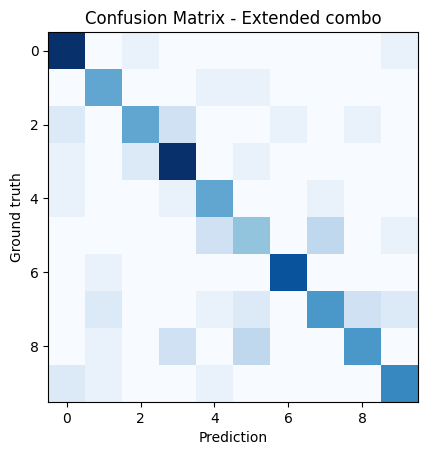

In [ ]:
def combo_extended(input):
    return np.concatenate((
        energy(input),
        duration(input),
        zcr(input),
        rms(input),
        mav(input),
        std_dev(input),
        crest_factor(input)
    ))

X_train, X_test, y_train, y_test = load_data(feature_extractor=combo_extended, normalize=True)
print('Dimensionality of the training features: {}'.format(X_train[0].shape))

param_grid = {'C': [0.1, 1, 10, 50, 100, 500, 1000, 5000],
              'gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5, n_jobs=-1)

t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

print('\nBest parameters:')
print(' C: ' + str(clf.best_estimator_.C))
print(' gamma: ' + str(clf.best_estimator_.gamma))
print(' Best CV score: %0.3f' % clf.best_score_)

y_pred = clf.predict(X_test)
print('\nClassification report (Extended combo):')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.title('Confusion Matrix - Extended combo')
plt.show()

**Observation:** adding RMS, MAV, standard deviation, and crest factor produces a **substantial improvement**: accuracy jumps from 50% (3 features) to **67%** (7 features), and the CV score rises to 66.9%. The new features provide complementary information: RMS and MAV are length-normalized measures of amplitude (unlike raw Energy, which scales with duration), standard deviation captures amplitude spread, and crest factor distinguishes peaky signals from smooth ones. Despite some correlation between features (e.g., RMS $\approx \sigma$ for zero-mean signals), the additional dimensions give the SVM kernel more room to find separating hyperplanes in the 7-dimensional feature space. The best hyperparameters ($C=5000$, $\gamma=0.01$) suggest a wider, smoother decision boundary compared to the 3-feature model.

## 8. Results comparison

ZCR only: accuracy = 0.240 (C=5000, gamma=1.0)
Energy + Duration: accuracy = 0.300 (C=1, gamma=5.0)
Energy + Duration + ZCR: accuracy = 0.500 (C=50, gamma=0.5)
All features (extended): accuracy = 0.673 (C=5000, gamma=0.01)


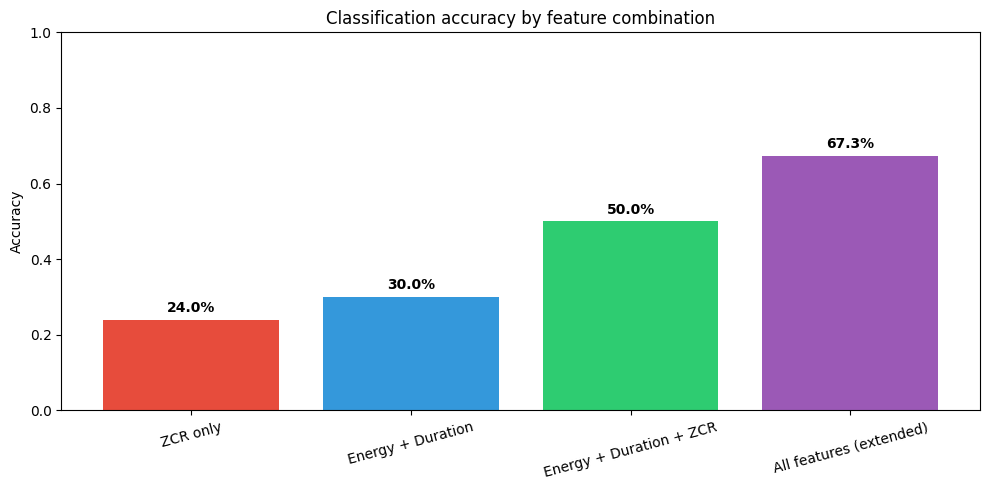

In [ ]:
def combo(input):
    return np.concatenate((energy(input), duration(input)))

configs = {
    'ZCR only': zcr,
    'Energy + Duration': combo,
    'Energy + Duration + ZCR': combo2,
    'All features (extended)': combo_extended,
}

results = {}
for name, feat_fn in configs.items():
    X_train, X_test, y_train, y_test = load_data(feature_extractor=feat_fn, normalize=True)

    param_grid = {'C': [0.1, 1, 10, 50, 100, 500, 1000, 5000],
                  'gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]}

    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    from sklearn.metrics import accuracy_score
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f'{name}: accuracy = {acc:.3f} (C={clf.best_estimator_.C}, gamma={clf.best_estimator_.gamma})')

plt.figure(figsize=(10, 5))
plt.bar(results.keys(), results.values(), color=['#e74c3c', '#3498db', '#2ecc71', '#9b59b6'])
plt.ylabel('Accuracy')
plt.title('Classification accuracy by feature combination')
plt.ylim(0, 1)
plt.xticks(rotation=15)
for i, (name, acc) in enumerate(results.items()):
    plt.text(i, acc + 0.02, f'{acc:.1%}', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

## Summary

| Configuration | Features | Dimensionality | Test Accuracy |
|---|---|:---:|:---:|
| ZCR only | ZCR | 1 | 24.0% |
| Energy + Duration | $E$, $|x|$ | 2 | 30.0% |
| Energy + Duration + ZCR | $E$, $|x|$, ZCR | 3 | 50.0% |
| All features (extended) | $E$, $|x|$, ZCR, RMS, MAV, $\sigma$, CF | 7 | **67.3%** |

**Key takeaways:**

1. **ZCR is a valuable feature** — adding it to the baseline Energy + Duration combo nearly doubles accuracy (30% → 50%), confirming that frequency-domain information is highly discriminative for digit classification.

2. **Feature normalization is critical** when combining features of different scales. Without z-score normalization, the SVM kernel is dominated by high-magnitude features (Energy $\sim 10^9$) and effectively ignores low-magnitude ones (ZCR $\in [0,1]$).

3. **More features help**, but there are diminishing returns. Going from 3 to 7 features improved accuracy by 17 percentage points, but some of the new features (RMS, $\sigma$) are partially redundant with Energy.

4. **Scalar features have a ceiling** — even with 7 features and optimized hyperparameters, accuracy plateaus around 67%. To go further, 2D features (Spectrogram, Mel Spectrogram, MFCC) that capture the full time-frequency structure of the signal are needed (explored in E02).

5. **Hyperparameter tuning matters less than feature engineering** — the extended grid search on 3 features (50%) was outperformed by a basic grid search on 7 features (67%), demonstrating that richer representations are more important than finer model tuning.